In [1]:
# filter(x -> occursin("SLURM", x), keys(ENV))
#ENV["SLURM_NNODES"]
#parse(Int, ENV["SLURM_JOB_CPUS_PER_NODE"])
pwd()

"/Users/julianschmitt/Documents/Research/loss/ClimaAtmos.jl/calibration/experiments/local_calibration"

In [4]:
# activate environment
using Pkg; Pkg.activate(".")

import ClimaAtmos as CA
import ClimaAnalysis: SimDir, get, slice, average_xy
using CairoMakie
import JLD2
import LinearAlgebra: I, Diagonal
import EnsembleKalmanProcesses as EKP
import Statistics: var, mean
using Test
using Revise
using ClimaCalibrate
using ClimaCore

# include("observation_map.jl")

# using Revise
# import ClimaCalibrate as CAL
# import ClimaAtmos as CA
# experiment_dir = joinpath(pkgdir(CA), "calibration", "experiments", "gcm_driven_scm")
# model_interface =
#     joinpath(pkgdir(CA), "calibration", "model_interface.jl")
# output_dir = joinpath("output", "gcm_driven_scm")
# # include model interface
# includet(model_interface)
# obs_path = joinpath(experiment_dir, "observations.jld2")


  Activating project at `/central/home/jschmitt/ClimaAtmos.jl/calibration/experiments/local_calibration`


ArgumentError: ArgumentError: Package ClimaCore not found in current path.
- Run `import Pkg; Pkg.add("ClimaCore")` to install the ClimaCore package.

## Calibration Evaluation and Setup

In [3]:
observations = JLD2.load_object(obs_path)
noise = 0.1 * I
n_iterations = 3
ensemble_size = 9
prior = CAL.get_prior(joinpath(experiment_dir, "prior.toml"))
experiment_config = CAL.ExperimentConfig(;
    n_iterations,
    ensemble_size,
    observations,
    noise,
    output_dir,
    prior,
)

InterruptException: InterruptException:

In [11]:
obs_path = joinpath(experiment_dir, "observations.jld2")
observations = JLD2.load_object(obs_path)
observations

1-element Vector{Float64}:
 285.0

In [ ]:
@everywhere begin
    using JLD2
    experiment_dir = dirname(Base.active_project())
    obs_path = joinpath(experiment_dir, "observations.jld2")
    if !isfile(obs_path)
        error("Observation file not found at: $obs_path")
    else
        println("Worker ", myid(), " can access the observations file.")
    end
end

In [ ]:
reshape(G_ens[1,:], 1, 10)
EKP.update_ensemble!(eki, reshape(G_ens[1,:], 1, 10))
CAL.save_eki_state(eki, output_dir, 1, prior)

## Visualization

In [2]:
# imports 
import EnsembleKalmanProcesses as EKP
using EnsembleKalmanProcesses.ParameterDistributions
using EnsembleKalmanProcesses.TOMLInterface
using Distributions
import Statistics: mean
import CairoMakie: Makie
import ClimaCalibrate

In [3]:
println(pwd())
output_dir = "output/local_calibration"
println(output_dir)
readdir(output_dir)

/central/home/jschmitt/ClimaAtmos.jl/calibration/experiments/local_calibration
output/local_calibration


11-element Vector{String}:
 "iteration_000"
 "iteration_001"
 "iteration_002"
 "iteration_003"
 "iteration_004"
 "iteration_005"
 "iteration_006"
 "iteration_007"
 "iteration_008"
 "iteration_009"
 "iteration_010"

In [3]:
import JLD2
iteration = 2
output_dir = joinpath("output", "local_calibration")
eki_filepath = joinpath(ClimaCalibrate.path_to_iteration(output_dir, iteration), "eki_file.jld2")
eki = JLD2.load_object(eki_filepath)
prior_path = joinpath("prior.toml")
prior = ClimaCalibrate.get_prior(prior_path);


In [4]:
eki.Δt

2-element Vector{Float64}:
 0.5
 0.5

In [82]:
size(vcat(EKP.transform_unconstrained_to_constrained(prior, EKP.get_u(eki))...), 2)

3

In [97]:
names = EKP.get_name(prior)

# get parameter data and put in matrix form 
params = EKP.transform_unconstrained_to_constrained(prior, EKP.get_u(eki))
params = EKP.transform_unconstrained_to_constrained(prior, EKP.get_u(eki))
params = vcat(params...)
params = reshape(params, length(names), eki.N_ens, iteration+1)
params = permutedims(params, (3, 1, 2));

In [98]:
params

3×5×9 Array{Float64, 3}:
[:, :, 1] =
 0.20239   1.09541  0.327738  0.00182666   0.264536
 0.134191  1.15848  0.240823  0.000939331  0.17366
 0.187268  1.15668  0.164576  0.00140629   0.204992

[:, :, 2] =
 0.183835  0.991973  0.264661  0.00131989   0.223264
 0.131605  1.11492   0.23334   0.000835688  0.163757
 0.187487  1.13229   0.165668  0.00132654   0.198496

[:, :, 3] =
 0.179343  0.98447  0.26111   0.00125577   0.220432
 0.133137  1.11976  0.235351  0.000855124  0.164526
 0.18578   1.12951  0.167357  0.00126735   0.195261

[:, :, 4] =
 0.134227  1.09128  0.235493  0.00128674  0.207376
 0.202251  1.34555  0.40708   0.00196699  0.223485
 0.155365  1.12097  0.317843  0.00149014  0.21459

[:, :, 5] =
 0.136898  1.07546  0.249101  0.00125129  0.203464
 0.170638  1.17786  0.27542   0.00124147  0.176715
 0.156591  1.09569  0.327786  0.00140419  0.207221

[:, :, 6] =
 0.139477  1.08025  0.261317  0.00121492  0.199638
 0.170342  1.17548  0.279088  0.00120068  0.174544
 0.159278  1.10011  0

In [99]:
mean(params[:, 3, :], dims = 2)

3×1 Matrix{Float64}:
 0.3194324369777986
 0.27415378973886934
 0.25940501387634013

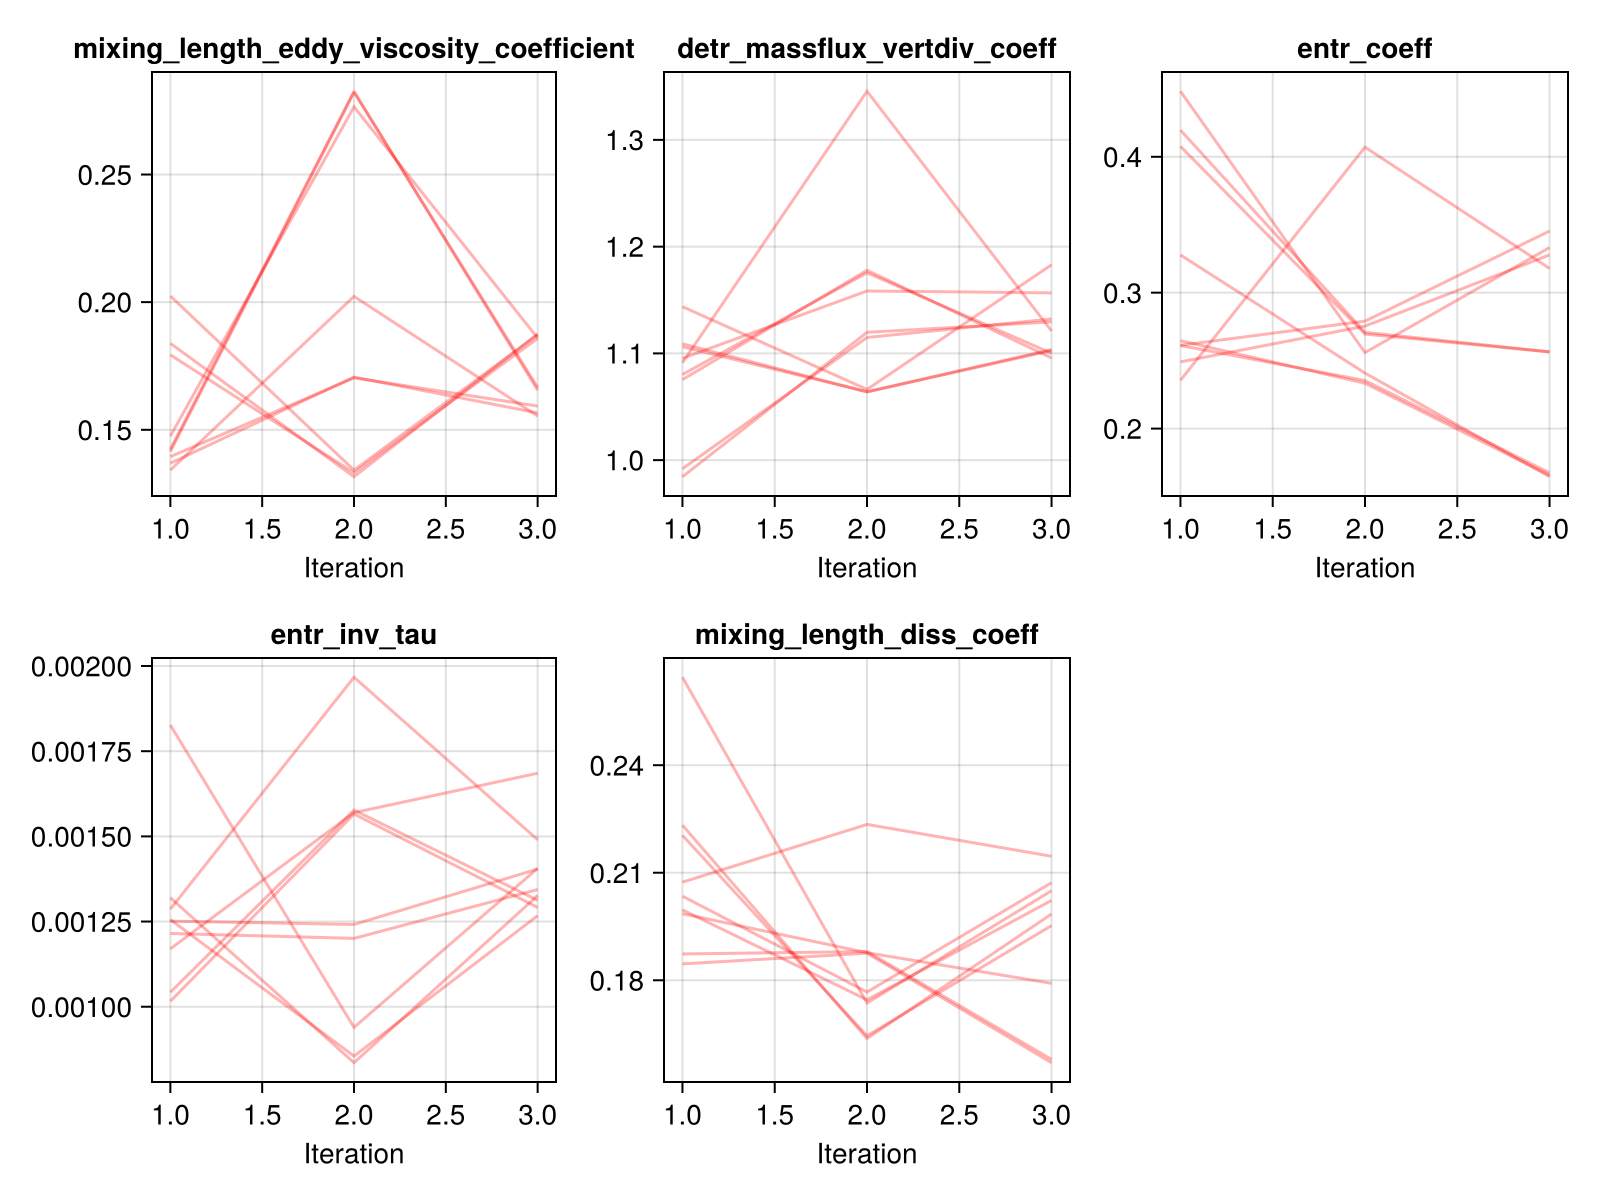

In [100]:
fig = Figure(size = (800, 600))

num_per_row = 3
for i in 1:length(names)
    row = div(i-1, num_per_row) + 1
    col = mod(i-1, num_per_row) + 1
    
    ax = Axis(fig[row, col], title = names[i], xlabel = "Iteration")
    
    for j in 1:size(params, 3)
        lines!(ax, 1:size(params, 1), params[:, i, j], color = :red, alpha = 0.3)
    end
end
fig

In [17]:
loss_vals = EKP.get_g(eki)
loss_vals[3]


9×100 Matrix{Float64}:
 405.721       405.721       405.721       …  405.725       405.717
   0.361834      0.360538      0.359776         0.358865      0.359113
   0.00415299    0.00413985    0.00413888       0.00409049    0.00409245
  10.1465        9.84033       9.38539          7.01006       7.12817
   8.67332e-5    8.34268e-5    7.64359e-5       5.54229e-5    5.45361e-5
 278.402       278.137       278.003       …  276.685       276.552
 290.854       290.853       290.864          290.405       290.385
 274.769       273.757       271.166          267.765       266.604
 123.1         123.092       123.076          123.039       123.039

In [15]:
# create a similar plot but show the loss function value (e.g., rlut) instead of the parameter value
fieldnames(EKP.EnsembleKalmanProcess)

(:u, :observation_series, :N_ens, :g, :err, :scheduler, :accelerator, :Δt, :process, :rng, :failure_handler, :localizer, :verbose)

In [80]:
mean(loss_vals[1,:][(!).(isnan.(loss_vals[1, :]))])

276.5868225097656

In [87]:
function mean_ignore_nan(arr, dim)
    mean_values = mapslices(x -> mean(x[(!).(isnan.(x))]), arr, dims=dim)
    return vec(mean_values)
end

mean_ignore_nan(loss_vals, 2)

5-element Vector{Float64}:
 276.5868225097656
 276.3648173014323
 275.94365844726565
 275.67548217773435
 275.2759053548177

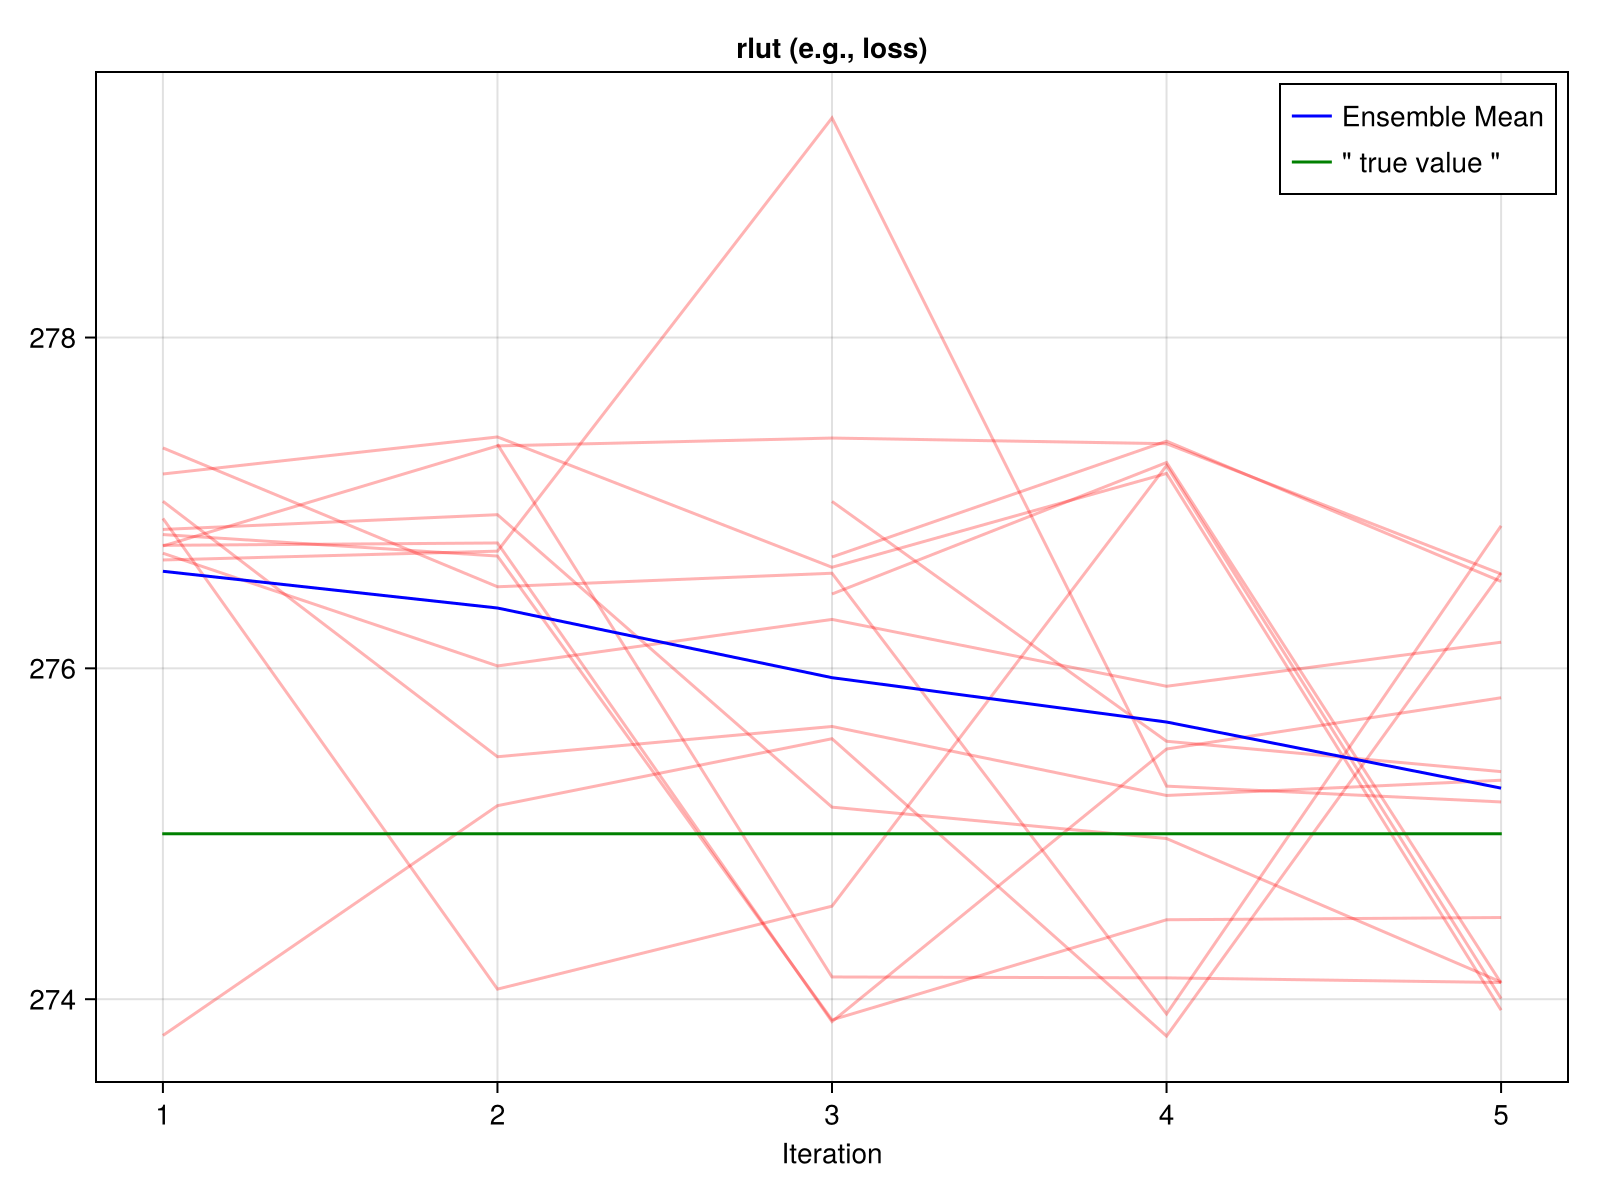

In [107]:
loss_vals = vcat(EKP.get_g(eki)...)

fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], title = "rlut (e.g., loss)", xlabel = "Iteration")
for i in 1:size(loss_vals, 2)
    lines!(ax, 1:size(loss_vals, 1), loss_vals[:, i], color = :red, alpha = 0.3)
end
lines!(ax, 1:size(loss_vals, 1), mean_ignore_nan(loss_vals, 2), color = :blue, label = "Ensemble Mean")
hlines!(ax, [275], xmin = .045, xmax= .955, color = :green, label = "\" true value \"")
# legend = Legend(fig, ax, tellwidth = false, tellheight = false)
# fig[1, 2] = legend
axislegend(ax, position = :rt)
fig
# size(loss_vals, 1)
# loss_vals[1][:]

# reshape loss_vals to be matrix 
# size(loss_vals)

In [145]:
# generate some plots of all variables for different simulations
# argmin(abs.(loss_vals .- 275))
best = argmin(replace(abs.(loss_vals .-275), NaN => Inf))
worst = argmax(replace(abs.(loss_vals .-275), NaN => -Inf))

println("Best: ", best, loss_vals[best])
println("Worst: ", worst, loss_vals[worst])


Best: CartesianIndex(4, 3)274.9712219238281
Worst: CartesianIndex(3, 6)279.3276062011719


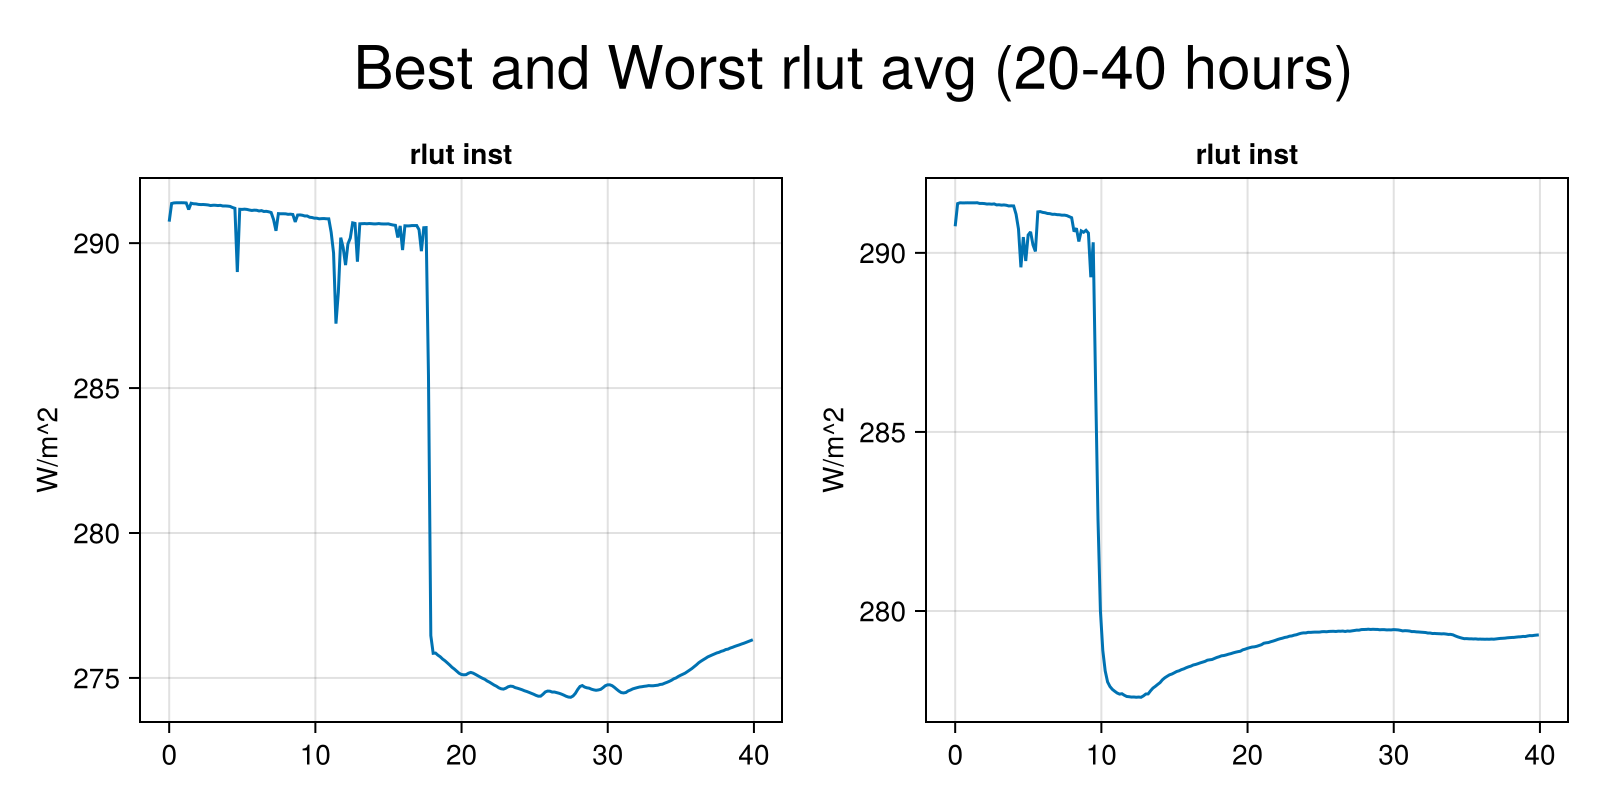

In [149]:
fig = Figure(size = (800, 400))
min_simdir = SimDir(joinpath("output", "gcm_driven_scm", "iteration_003", "member_003","output_active"))
max_simdir = SimDir(joinpath("output", "gcm_driven_scm", "iteration_002", "member_006","output_active"))

add_var(fig, "rlut", min_simdir, 1, 1, lines = true)
add_var(fig, "rlut", max_simdir, 1, 2, lines = true)
supertitle = Label(fig[0, :], "Best and Worst rlut avg (20-40 hours)", fontsize = 30)

fig

In [3]:
#simdir = SimDir(joinpath("output", "gcm_driven_scm", "iteration_004", "member_001","output_active"))
# println(summary(simdir))

function add_var(fig, var, simdir = simdir, col = 1, ind = 1; lines = false, reduction = "inst")
    # get data 
    da = get(simdir; short_name = var, reduction = "inst")
    title = "$var $reduction"
    if lines
        ax = Axis(fig[col, ind], ylabel = "W/m^2", title = title)
        ln = lines!(da.dims["time"]/ 21600*6, da.data[:, 1, 1])
       # Colorbar(fig[col, ind+1], ln, label = var)
    elseif var == "wa"
        ax = Axis(fig[col, ind][1, 1], ylabel = "height (km)", xlabel="time (hrs)", title = title)
        hm = heatmap!(da.dims["time"][1:end]/ 21600*6, 
                      da.dims["z"][1:20]/1000,
                      da.data[1:end, 1, 1, 1:20])
        Colorbar(fig[col, ind][1,2], hm)
    else
        ax = Axis(fig[col, ind][1, 1], ylabel = "height (km)", xlabel="time (hrs)", title = title)
        hm = heatmap!(da.dims["time"]/ 21600*6, 
                      da.dims["z"][1:20]/1000,
                      da.data[:, 1, 1, 1:20])
        Colorbar(fig[col, ind][1,2], hm)
    end
end

function plot_defaults(dirname)
    simdir = SimDir(dirname)

    fig = Figure(size=(1400,800))

    vars = ["clw", "wa", "entr", "hus", "rlut", "rlutcs", "rsut", "rsutcs", "waup", "tke"]
    for (ind, var) in enumerate(["ta", "wa", "clw", "cl", "rlut", "rlutcs", "rsut", "rsutcs", "waup", "tke", "arup", "entr", "detr"])
        if var in ["rlut", "rlutcs", "rsut", "rsutcs"] # add lines
            add_var(fig, var, simdir, ind % 4 + 1, div(ind, 4) + 1, lines = true)
        else
            add_var(fig, var, simdir, ind % 4 + 1, div(ind, 4) + 1)
        end
    end
    add_var(fig, "tke", simdir, 1, 1, lines = false, reduction = "max")

    fig 
end

plot_defaults(joinpath("output", "gcm_driven_scm", "iteration_003", "member_003","output_active"))

plot_defaults (generic function with 1 method)

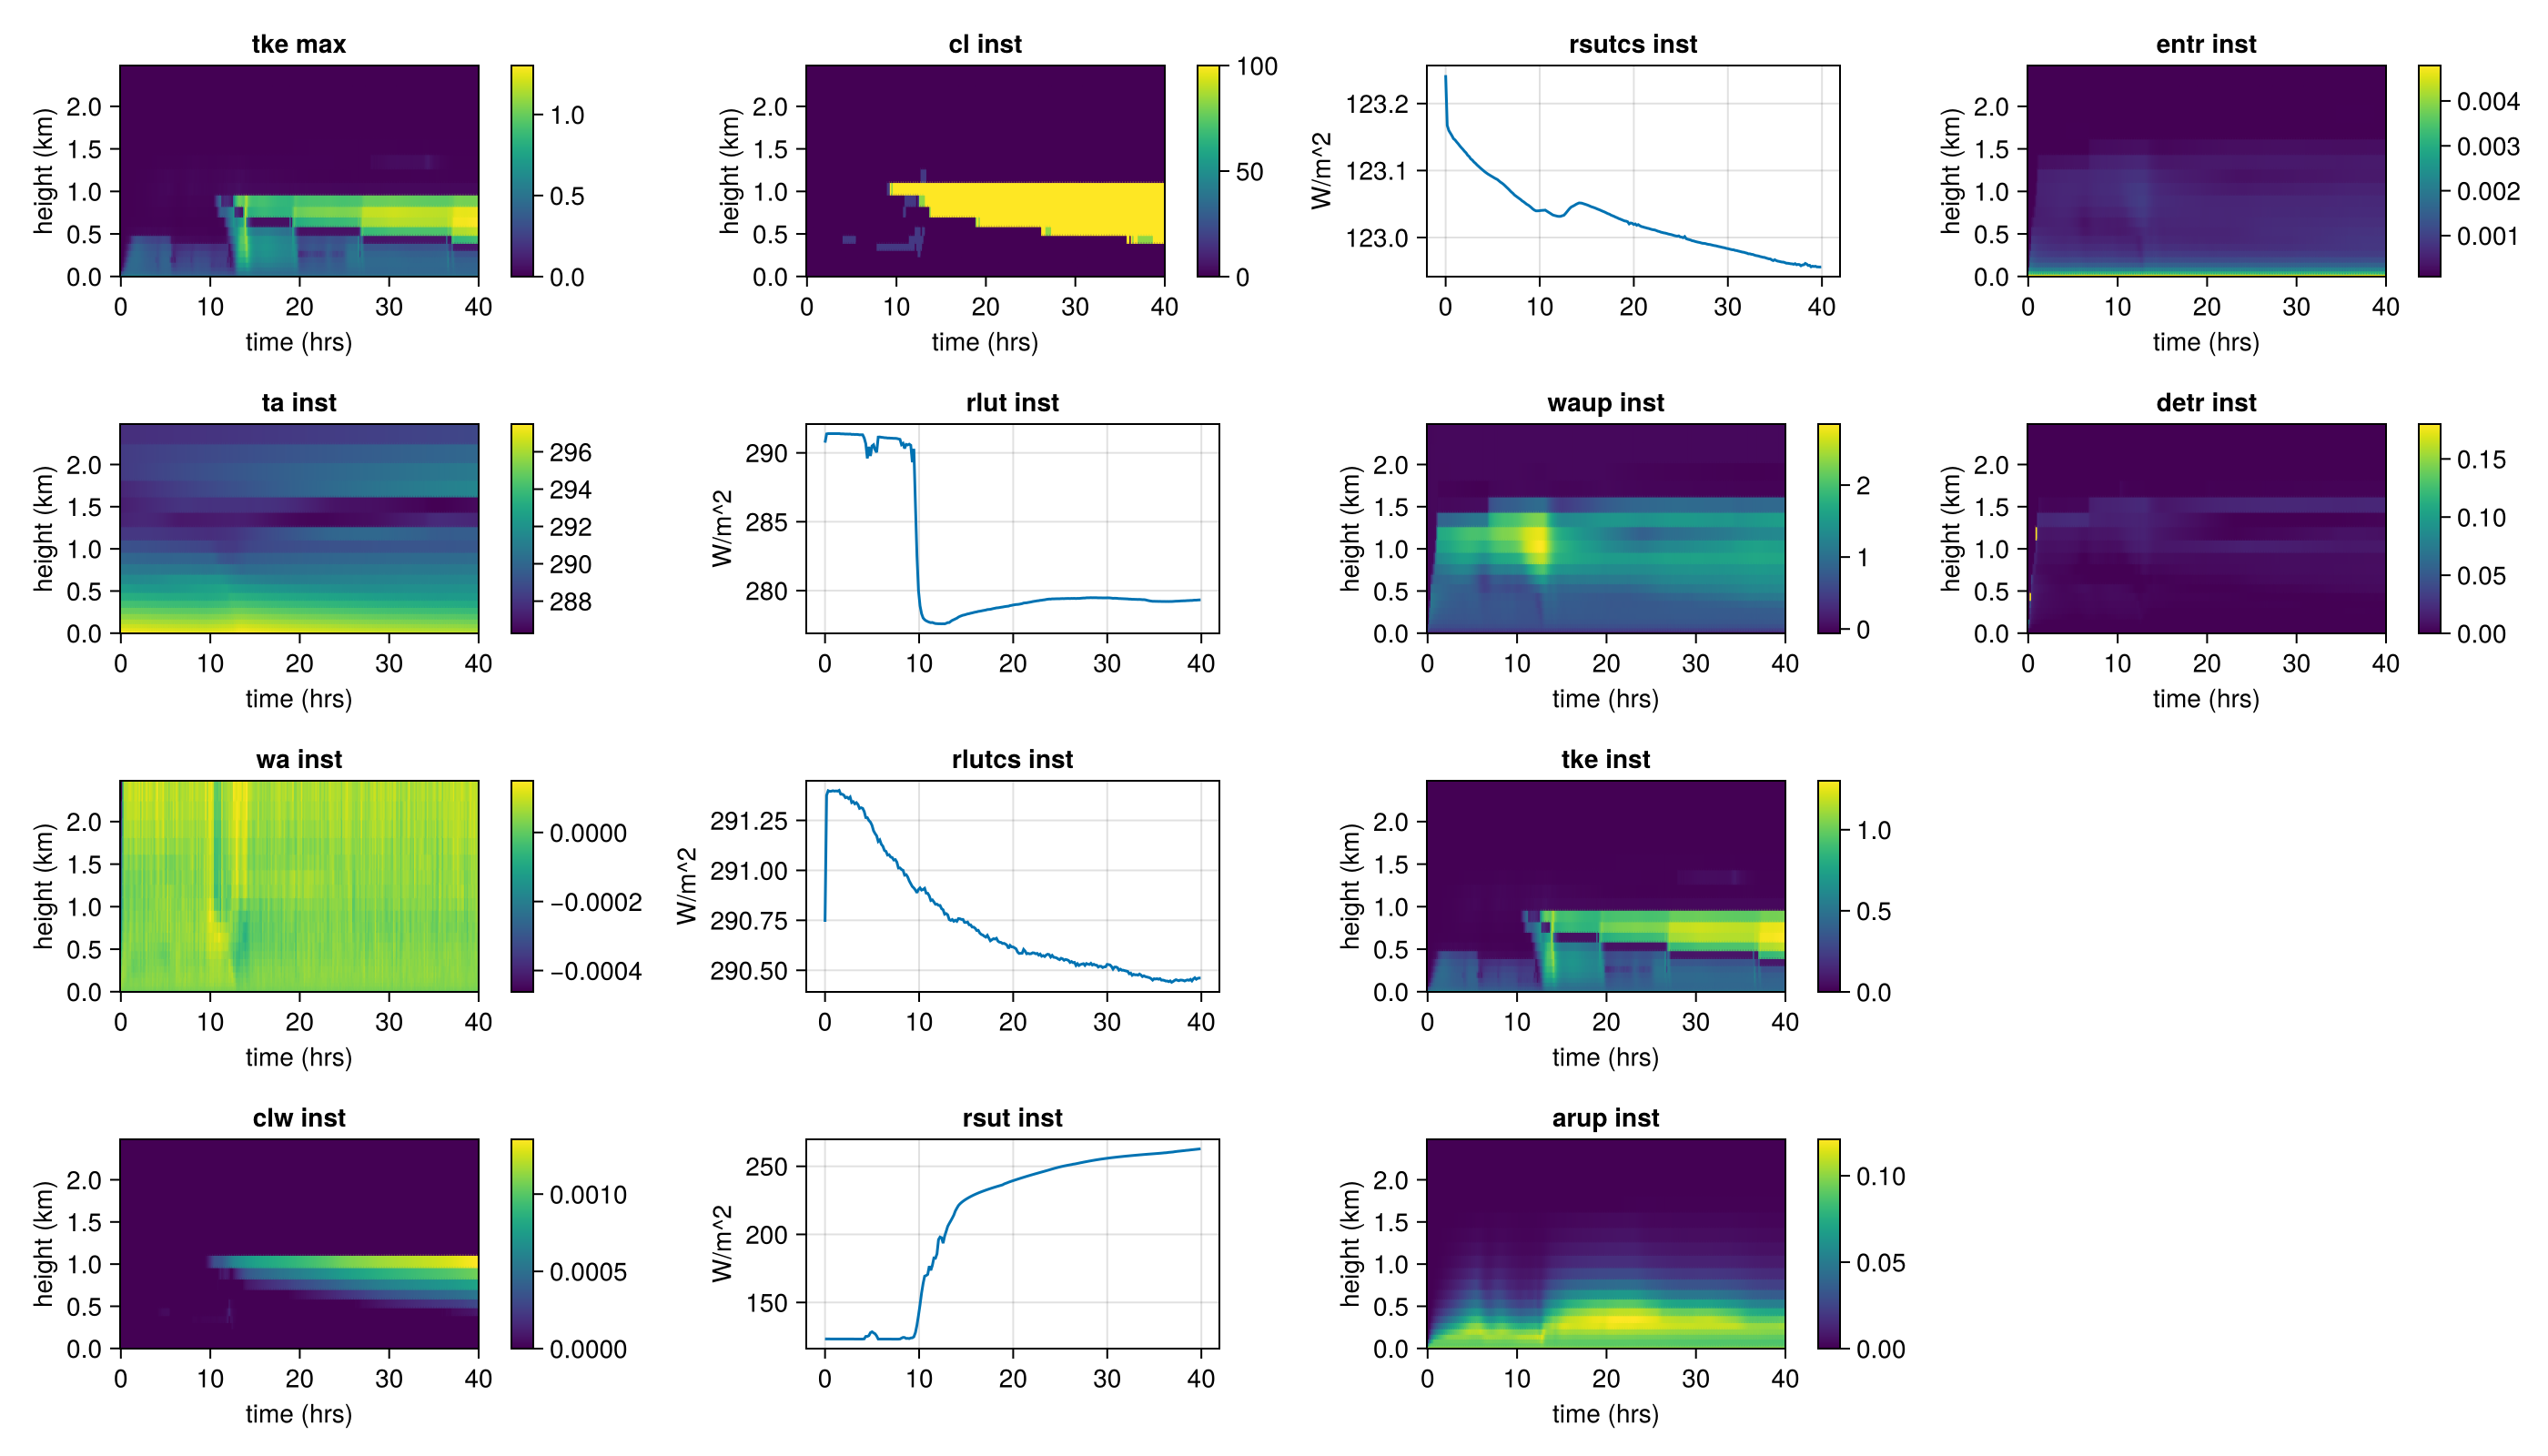

In [151]:
plot_defaults(joinpath("output", "gcm_driven_scm", "iteration_002", "member_006","output_active"))

## Dev function to generate profiles

In [5]:
import YAML
import ClimaAnalysis: SimDir, get, slice, average_xy, available_vars, window, average_time

In [19]:
pwd()
simpath = joinpath("output", "local_calibration", "output_active")
simdir = SimDir(simpath)
variables = collect(available_vars(simdir))

46-element Vector{Any}:
 "rhoa"
 "taen"
 "pr"
 "waup"
 "wa"
 "ua"
 "cli"
 "thetaaup"
 "hussfc"
 "tke"
 ⋮
 "huren"
 "clw"
 "va"
 "husen"
 "pfull"
 "rlutcs"
 "clien"
 "hurup"
 "waen"

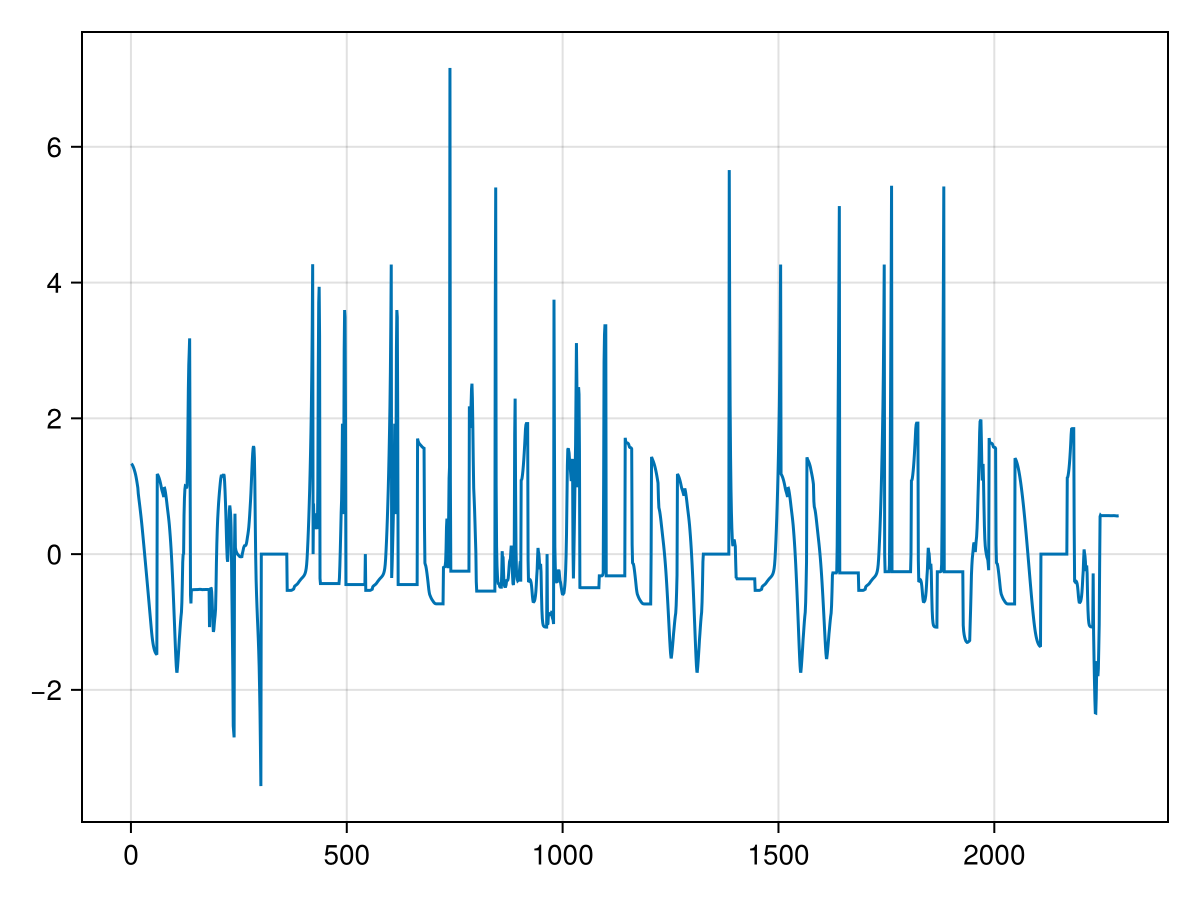

In [25]:
fieldnames(typeof(simdir))
# read in experiment config 
experiment_config = YAML.load_file("experiment_config.yml")

# # compute the window time average
# da_var = get(simdir; short_name = "ta", reduction = "inst")
# da_slice = window(da_var, "time", left = experiment_config["g_t_start_sec"], right = experiment_config["g_t_end_sec"])
# da_slice = average_time(da_slice)
# da_slice.data[1, 1, :]


function extract_profile(simdir, var, experiment_config)
    da_var = get(simdir; short_name = var, reduction = "inst")
    da_slice = window(da_var, "time", left = experiment_config["g_t_start_sec"], right = experiment_config["g_t_end_sec"])
    da_slice = average_time(da_slice)
    return da_slice.data[1, 1, :]
end

# function to extract all profiles from a simulation directory
function extract_profiles(simdir, experiment_config)
    profiles = Dict()
    for variable in available_vars(simdir)
        profile = extract_profile(simdir, variable, experiment_config)
        profiles[variable] = Dict("profile" => profile, "μ" => mean(profile), "σ²" => var(profile))
    end
    return profiles
end

profiles = extract_profiles(simdir, experiment_config)

# combine profiles into a single vector, normalizing by mean and variance 
function combine_profiles(profiles)
    profile_vec = []
    for variable in available_vars(simdir)
        profile = profiles[variable]["profile"]
        μ = profiles[variable]["μ"]
        σ² = profiles[variable]["σ²"]
        profile = σ² > 0 ? (profile .- μ) ./ sqrt(σ²) : profile .- μ
        append!(profile_vec, profile)
    end
    return profile_vec
end
combined = combine_profiles(profiles)
lines(combined)

In [23]:
tapio_loss_vars = ["ta", "thetaa", "ha", "rhoa", 
                    "hur", "hus", "cl", "clw",
                     "hussfc", 
                     "rlut", "rlutcs", "rsut", "rsutcs"]
# extract all profiles for all simulations with fixed relative error
function combine_profiles(simdir, experiment_config; vars = tapio_loss_vars)
    profiles = extract_profiles(simdir, experiment_config, vars = vars)
    profile_vec = Float64[]
    var_vec = Float64[]
    for variable in vars
        profile = profiles[variable]["profile"]
        μ = profiles[variable]["μ"]
        σ² = profiles[variable]["σ²"]

        #profile = σ² > 0 ? (profile .- μ) ./ sqrt(σ²) : profile .- μ
        if variable in ["rlut", "rlutcs", "rsut", "rsutcs"]
            append!(profile_vec, profile) 
            append!(var_vec, 1) # typical error of 1 W/m^2 for radiative variables
        elseif variable in ["hussfc"]
            append!(profile_vec, profile)
            append!(var_vec, 1e-4) 
        else
            append!(profile_vec, profile)
            append!(var_vec, repeat([σ²], length(profile))) # 1% relative error
        end
    end
    return profile_vec, var_vec
end

function extract_profiles(simdir, experiment_config; vars = tapio_loss_vars)
    profiles = Dict()
    for variable in vars
        profile = extract_profile(simdir, variable, experiment_config)
        # add artificial noise to the profile
        profile = profile .* (1 .+ randn(length(profile)) ./ 100)
        profiles[variable] = Dict("profile" => profile, "μ" => mean(profile), "σ²" => var(profile))
    end
    return profiles
end


#cat_profile, noise = combine_profiles(simdir, experiment_config, vars = tapio_loss_vars)

extract_profiles (generic function with 1 method)

In [34]:
experiment_config = YAML.load_file("experiment_config.yml")

function extract_profiles_int(simdir, experiment_config; vars = tapio_loss_vars)
    profiles = Dict()
    for variable in vars
        profile = extract_profile(simdir, variable, experiment_config)
        # take vertical mean
        profile = mean(profile)
        # add 1% artificial noise to the profile
        profile = profile .* (1 .+ randn(length(profile)) ./ 100)
        profiles[variable] = Dict("profile" => profile, "σ²" => profile/100)
    end
    return profiles
end
extract_profiles_int(simdir, experiment_config, vars = ["thetaa", "hur", "hus", "cl", "clw", "rlut", "rlutcs", "rsut", "rsutcs"])

Dict{Any, Any} with 9 entries:
  "cl"     => Dict("profile"=>[8.79035], "σ²"=>[0.0879035])
  "rsutcs" => Dict("profile"=>[122.051], "σ²"=>[1.22051])
  "clw"    => Dict("profile"=>[7.11491e-5], "σ²"=>[7.11491e-7])
  "rlutcs" => Dict("profile"=>[288.558], "σ²"=>[2.88558])
  "hus"    => Dict("profile"=>[0.00409013], "σ²"=>[4.09013e-5])
  "rlut"   => Dict("profile"=>[276.452], "σ²"=>[2.76452])
  "hur"    => Dict("profile"=>[0.356839], "σ²"=>[0.00356839])
  "thetaa" => Dict("profile"=>[401.698], "σ²"=>[4.01698])
  "rsut"   => Dict("profile"=>[278.46], "σ²"=>[2.7846])

In [35]:
get(simdir; short_name = "rsutcs", reduction = "inst").data

249×2×2 Array{Float32, 3}:
[:, :, 1] =
 123.242  123.242
 123.167  123.167
 123.16   123.16
 123.156  123.156
 123.152  123.152
 123.15   123.15
 123.147  123.147
 123.144  123.144
 123.142  123.142
 123.139  123.139
   ⋮      
 123.034  123.034
 123.034  123.034
 123.033  123.033
 123.033  123.033
 123.033  123.033
 123.033  123.033
 123.032  123.032
 123.032  123.032
 123.031  123.031

[:, :, 2] =
 123.242  123.242
 123.167  123.167
 123.16   123.16
 123.156  123.156
 123.152  123.152
 123.15   123.15
 123.147  123.147
 123.144  123.144
 123.142  123.142
 123.139  123.139
   ⋮      
 123.034  123.034
 123.034  123.034
 123.033  123.033
 123.033  123.033
 123.033  123.033
 123.033  123.033
 123.032  123.032
 123.032  123.032
 123.031  123.031

In [52]:
function cat_obs(dict)
    obs = Float64[]
    vars = Float64[]
    for (key, value) in dict
        append!(obs, value["profile"])
        append!(vars, value["σ²"])
    end
    return obs, vars
end 
obs, obs_variance = cat_obs(extract_profiles_int(simdir, experiment_config, 
            vars = ["thetaa", "hur", "hus", "cl", "clw", "rlut", "rlutcs", "rsut", "rsutcs"]))
obs, obs_variance

([8.633257615267864, 123.89262582367597, 7.187324041971504e-5, 292.69537820467156, 0.004106470043546203, 282.0426576280664, 0.3602339510686849, 413.138604150189, 274.37836958269037], [0.08633257615267864, 1.2389262582367597, 7.187324041971504e-7, 2.9269537820467155, 4.106470043546203e-5, 2.8204265762806644, 0.0036023395106868487, 4.13138604150189, 2.7437836958269037])

In [54]:
Diagonal(obs_variance)

9×9 Diagonal{Float64, Vector{Float64}}:
 0.0863326   ⋅        ⋅           ⋅       …   ⋅           ⋅        ⋅ 
  ⋅         1.23893   ⋅           ⋅           ⋅           ⋅        ⋅ 
  ⋅          ⋅       7.18732e-7   ⋅           ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅          2.92695      ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅           ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅       …   ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅          0.00360234   ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅           ⋅          4.13139   ⋅ 
  ⋅          ⋅        ⋅           ⋅           ⋅           ⋅       2.74378

In [55]:
# save 
JLD2.save_object("observations.jld2", obs)
JLD2.save_object("obs_noise_cov.jld2", Diagonal(obs_variance))

## Integral definitions

In [6]:
import YAML
# [thetaa, hur, hus, cl, clw, cli, rlut, rlutcs, rsut, rsutcs]
simdir = SimDir(joinpath("output", "local_calibration", "iteration_000", "member_001","output_active"))
config_dict = YAML.load_file("experiment_config.yml")

Dict{Any, Any} with 12 entries:
  "y_var_names"   => ["thetaa", "hur", "hus", "cl", "clw", "rlut", "rlutcs", "r…
  "prior"         => "prior.toml"
  "batch_size"    => 1
  "output_dir"    => "output/local_calibration"
  "g_t_start_sec" => 72000.0
  "g_t_end_sec"   => 144000.0
  "ensemble_size" => 25
  "noise"         => "obs_noise_cov.jld2"
  "observations"  => "observations.jld2"
  "n_iterations"  => 5
  "model_config"  => "model_config.yml"
  "dims"          => 9

In [11]:
# HUS
hus_profile = get(simdir, short_name = "hus")
hus_profile.dims["z"]

60-element Vector{Float32}:
    15.0
    49.13878
    91.66503
   142.80383
   202.79102
   271.87396
   350.3122
   438.37814
   536.3576
   644.5504
     ⋮
 22572.047
 23997.504
 25534.7
 27200.482
 29016.207
 31009.55
 33217.312
 35690.04
 38500.0

In [13]:
hus_profile.dims

OrderedCollections.OrderedDict{String, Vector{Float32}} with 4 entries:
  "time" => [0.0, 600.0, 1200.0, 1800.0, 2400.0, 3000.0, 3600.0, 4200.0, 4800.0…
  "x"    => [0.0, 1.0]
  "y"    => [0.0, 1.0]
  "z"    => [15.0, 49.1388, 91.665, 142.804, 202.791, 271.874, 350.312, 438.378…

In [60]:
function process_member_data(
    simdir;
    y_names,
    reduction = "inst",
    t_start,
    t_end,
    # norm_vec_obs = [0.0, 1.0],
    # normalize = true,
)

    g = Float64[]

    for (i, y_name) in enumerate(y_names)
        var_i = get(simdir; short_name = y_name, reduction = reduction)
        sim_t_end = var_i.dims["time"][end]

        if sim_t_end < 0.95 * t_end
            throw(ErrorException("Simulation failed."))
        end
        # take time-mean
        var_i_ave = average_time(
            window(var_i, "time", left = t_start, right = sim_t_end),
        )

        y_var_i = slice(var_i_ave, x = 1, y = 1).data
        # if normalize
        #     y_μ, y_σ = norm_vec_obs[i, 1], norm_vec_obs[i, 2]
        #     y_var_i = (y_var_i .- y_μ) ./ y_σ
        # end

        append!(g, mean(y_var_i))
    end

    return g
end
process_member_data(simdir, y_names = ["ta", "rlut", "clw"], t_start = 86400, t_end = 140000)

3-element Vector{Float64}:
 258.6385803222656
 277.5313720703125
   7.743311289232224e-5

In [65]:
G_ensemble = Array{Float64}(
    undef,
    9,
    5,
)
G_ensemble[:, 1] .= process_member_data(simdir, y_names = ["thetaa", "hur", "hus", "cl", "clw", "rlut", "rlutcs", "rsut", "rsutcs"], t_start = 86400, t_end = 140000)
G_ensemble

9×5 Matrix{Float64}:
 405.727       6.27335e-314  6.27336e-314  6.32789e-314  6.27336e-314
   0.359       6.32789e-314  6.27336e-314  6.27335e-314  6.27336e-314
   0.0040859   6.32989e-314  6.27336e-314  6.27335e-314  6.27336e-314
   9.06688     6.32989e-314  6.29821e-314  6.27335e-314  1.5e-323
   7.74331e-5  6.33184e-314  6.27335e-314  6.27335e-314  4.74e-322
 277.531       6.32587e-314  6.27336e-314  6.32789e-314  1.0e-323
 290.4         6.33083e-314  5.0e-324      6.32789e-314  2.08e-322
 276.585       0.0           6.32789e-314  6.32789e-314  5.97159e-314
 123.06        6.27335e-314  6.32789e-314  6.27336e-314  6.29242e-314

In [63]:
G_ensemble

3×5 Matrix{Float64}:
 258.639       3.15252e-314  0.0           0.0  0.0
 277.531       0.0           3.15363e-314  0.0  0.0
   7.74331e-5  0.0           0.0           0.0  3.15363e-314

In [174]:
# examine eki files
eki = JLD2.load_object("output/local_calibration/iteration_003/eki_file.jld2")
eki

EnsembleKalmanProcesses.EnsembleKalmanProcess{Float64, Int64, EnsembleKalmanProcesses.Inversion, EnsembleKalmanProcesses.DefaultScheduler{Float64}, EnsembleKalmanProcesses.DefaultAccelerator}(EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}[EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}([-1.9067828240772768 -2.0329857339977924 … -1.8364840894918002 -2.0277081424839087; 0.14555099867397547 0.11419519730477608 … 0.10907643207586122 0.083684820060044; … ; -9.226732797084804 -9.198773076822519 … -9.091094849581513 -9.220298140164312; -1.5630794342706944 -1.560008246576264 … -1.509050359332279 -1.5492521486676536]), EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}([-1.8032733567955133 -1.9013981871605183 … -1.7014646876524795 -1.8461023484802628; 0.21092911915398233 0.2065404238101448 … 0.182779926620468 0.21553806348757876; … ; -9.311725970536294 -9.303630373735178 … -9.195090387408772 -9.288235402150404; -1.5238050331597812 -1.5170278589089146 … -1

In [70]:
function observation_map(iteration)

    G_ensemble = Array{Float64}(
        undef,
        config_dict["dims"]...,
        config_dict["ensemble_size"],
    )

    # f_diagnostics = JLD2.jldopen(
    #     joinpath(config_dict["output_dir"], "norm_vec_obs.jld2"),
    #     "r+",
    # )

    for m in 1:config_dict["ensemble_size"]
        member_path = TOMLInterface.path_to_ensemble_member(
            config_dict["output_dir"],
            iteration,
            m,
        )
        simdir = SimDir(joinpath(member_path, "output_active"))
        try
            G_ensemble[:, m] .= process_member_data(
                simdir;
                y_names = config_dict["y_var_names"],
                t_start = config_dict["g_t_start_sec"],
                t_end = config_dict["g_t_end_sec"],
                # norm_vec_obs = f_diagnostics["norm_vec_obs"],
            )
        catch err
            @info "Error during observation map for ensemble member $m" err
            G_ensemble[:, m] .= NaN
        end
    end
    return G_ensemble
end
config_dict = YAML.load_file("experiment_config.yml")
import ClimaCalibrate: TOMLInterface
observation_map(2)

9×3 Matrix{Float64}:
 405.712       405.721       405.704
   0.361189      0.361648      0.365525
   0.00411815    0.00415785    0.00427071
   7.29877       9.52975      14.1426
   4.79198e-5    7.77002e-5    0.000119092
 276.562       277.866       279.46
 290.371       290.831       291.44
 260.016       271.49        271.561
 123.0         123.073       123.13